In [16]:
from sklearn.decomposition import PCA
from sklearn.random_projection import SparseRandomProjection
import sklearn, scipy

from minisom import MiniSom

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import datasets
from sklearn.preprocessing import scale

from sklearn.cluster import KMeans

from colour import Color
from graphviz import Digraph

import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx

import pandas as pd
import gin
import seaborn as sns

In [17]:
gin.enter_interactive_mode()

In [69]:
df_pivot = pd.read_csv('../../results/pairs_win_rate_player_1_pbt_1adv.csv', index_col=0)

In [70]:
df_pivot_norm = pd.DataFrame(sklearn.preprocessing.normalize(df_pivot))
df_pivot_norm.index = df_pivot.index
df_pivot_norm.columns = df_pivot.columns

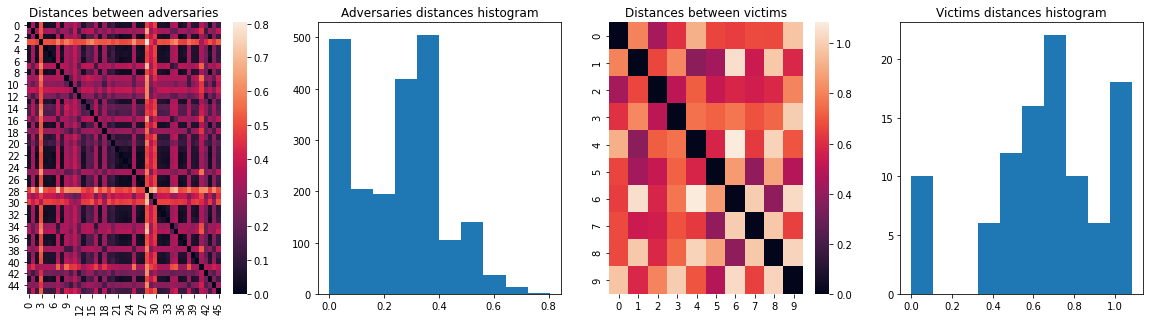

In [71]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.title("Distances between adversaries")
dist_pairs = scipy.spatial.distance.cdist(df_pivot_norm, df_pivot_norm)
sns.heatmap(dist_pairs)

plt.subplot(1, 4, 2)
plt.title("Adversaries distances histogram")
plt.hist(dist_pairs.flatten())

plt.subplot(1, 4, 3)
plt.title("Distances between victims")
dist_pairs = scipy.spatial.distance.cdist(df_pivot_norm.T, df_pivot_norm.T)
sns.heatmap(dist_pairs)

plt.subplot(1, 4, 4)
plt.title("Victims distances histogram")
plt.hist(dist_pairs.flatten())
plt.show()

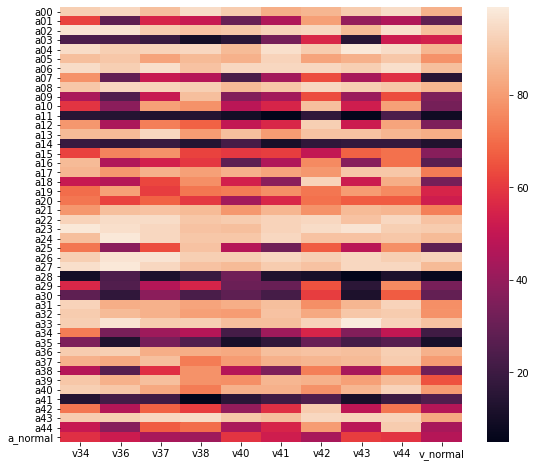

In [76]:
plt.figure(figsize=(9, 8))
sns.heatmap(df_pivot, xticklabels=df_pivot.columns, yticklabels=df_pivot.index)
plt.show()

(array([ 25.,  29.,  29.,  22.,  37.,  35.,  23.,  49.,  98., 113.]),
 array([ 5. , 14.4, 23.8, 33.2, 42.6, 52. , 61.4, 70.8, 80.2, 89.6, 99. ]),
 <BarContainer object of 10 artists>)

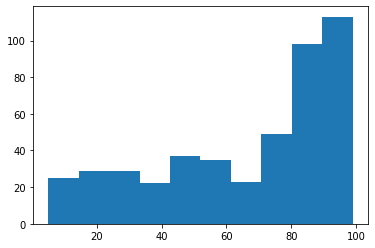

In [78]:
plt.hist(np.array(df_pivot).flatten())

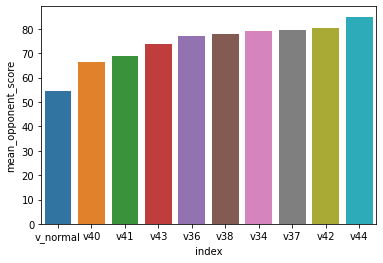

In [113]:
victim_df = pd.DataFrame({'mean_opponent_score': np.median(np.array(df_pivot), axis=0),
                         'index': df_pivot.columns})
victim_df = victim_df.sort_values('mean_opponent_score')
ax = sns.barplot(x="index", y="mean_opponent_score", data=victim_df)

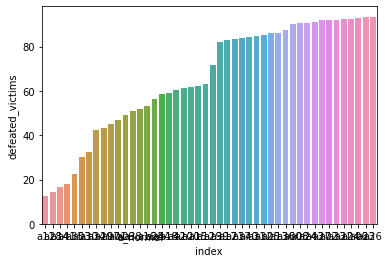

In [106]:
opp_df = pd.DataFrame({'defeated_victims': np.array(df_pivot).mean(axis=1),
                         'index': df_pivot.index})
opp_df = opp_df.sort_values('defeated_victims')
ax = sns.barplot(x="index", y="defeated_victims", data=opp_df)

In [114]:
assert df_pivot.index[0][0] == 'a'
assert df_pivot.columns[0][0] == 'v'

In [115]:
PCA = gin.external_configurable(PCA)
KMeans = gin.external_configurable(KMeans)

In [116]:
@gin.configurable
def cluster_vectors(method, vectors, visual_method=None, names=None, plot=False):
    """Cluster input vectors using a method."""
    m = method()
    out = m.fit_transform(vectors)
    n_clusters = len(m.cluster_centers_)
    clusters = range(n_clusters)
    n_data = len(vectors)
    dist_vec_cluster = scipy.spatial.distance.cdist(vectors, m.cluster_centers_)
    items_in_cluster = {cluster: [i for i in range(n_data) if m.labels_[i] == cluster]
                        for cluster in range(n_clusters)}
#     print(items_in_cluster)
    
    closest_to_center = [np.argmin([dist_vec_cluster[v, c] for v in items_in_cluster[c]]) for c in clusters]
    closest_to_center = [items_in_cluster[c][closest_idx] for closest_idx, c in zip(closest_to_center, clusters)]
#     print(closest_to_center)

    names_aggregate = [' '.join([names[i] for i in items_in_cluster[c]]) for c in clusters]
    
#     print(names_aggregate)
    
    # showing the visualization
    if plot and visual_method is not None:
        assert len(vectors) == len(names)
        vis = visual_method(n_components=2)
        v_pca = vis.fit_transform(vectors)
        plt.figure(figsize=(10, 5))
        plt.title(f"Clustering with {method.__name__}, {n_clusters} clusters, {visual_method.__name__} space")
        plt.scatter(v_pca[:, 0], v_pca[:, 1], c=m.labels_)
        for i in range(n_data):
            plt.text(x=v_pca[i, 0], y=v_pca[i, 1], s=names[i])
            
        c_pca = vis.transform(m.cluster_centers_)
        plt.scatter(c_pca[:, 0], c_pca[:, 1], c=clusters, s=150)
        for c in clusters:
            closest_idx = closest_to_center[c]
            plt.scatter(*v_pca[closest_idx, :], marker='2', c=c, s=150)
        
        plt.show()
    
    return {'labels': m.labels_,
            'clusters': m.cluster_centers_,
            'closest_to_center': closest_to_center,
            'names': names_aggregate}

In [143]:
gin.bind_parameter("KMeans.n_clusters", 9)
gin.bind_parameter("cluster_vectors.method", KMeans)
gin.bind_parameter("cluster_vectors.visual_method", PCA)

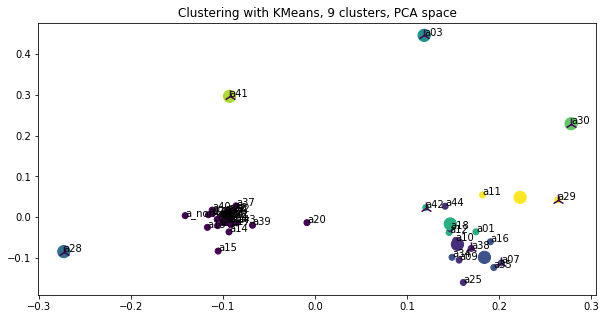

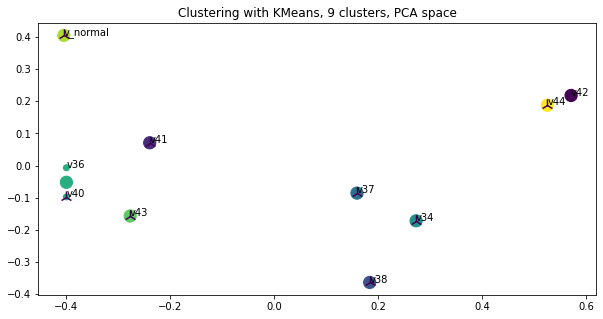

In [144]:
clustered_adversaries = cluster_vectors(vectors=df_pivot_norm, plot=True, names=df_pivot.index)
clustered_victims = cluster_vectors(vectors=df_pivot_norm.T, plot=True, names=df_pivot.columns)

In [145]:
clustered_victims

{'labels': array([4, 5, 3, 2, 5, 1, 0, 6, 8, 7], dtype=int32),
 'clusters': array([[0.30155397, 0.51928412, 0.3221635 , 0.5135238 , 0.31019022,
         0.30114513, 0.31950249, 0.41542679, 0.32723823, 0.38778621,
         0.43406143, 0.39072717, 0.44305076, 0.32539013, 0.31470691,
         0.2492162 , 0.42474674, 0.30043887, 0.47356615, 0.31571357,
         0.35922325, 0.29557968, 0.32195746, 0.32180471, 0.30942533,
         0.35618148, 0.31108966, 0.3060082 , 0.2111873 , 0.43557505,
         0.5248295 , 0.28625327, 0.30654449, 0.3187512 , 0.38922023,
         0.39507899, 0.32105913, 0.32399126, 0.43377332, 0.3258212 ,
         0.2911725 , 0.41585884, 0.46211949, 0.32535302, 0.41405782,
         0.26578947],
        [0.29454109, 0.29490209, 0.31873623, 0.30261224, 0.32723364,
         0.34154265, 0.31950249, 0.27911488, 0.3133132 , 0.26054386,
         0.27128839, 0.11491976, 0.26968307, 0.29248551, 0.20363388,
         0.30404377, 0.25708355, 0.31184794, 0.19350015, 0.33763812,
      

In [146]:
df_clustered = df_pivot.iloc[clustered_adversaries['closest_to_center'], clustered_victims['closest_to_center']].copy()
df_clustered.index = clustered_adversaries['names']
df_clustered.columns = clustered_victims['names']
df_clustered

,v42,v41,v38,v37,v34,v36 v40,v43,v_normal,v44
a00 a02 a04 a05 a06 a08 a13 a14 a15 a17 a19 a20 a21 a22 a23 a24 a26 a27 a31 a32 a33 a36 a37 a39 a40 a43 a_normal,89.0,91.0,89.0,94.0,96.0,87.0,94.0,87.0,94.0
a09 a10 a18 a25 a38 a44,74.0,35.0,78.0,58.0,47.0,47.0,44.0,32.0,70.0
a07 a16 a34 a35,64.0,43.0,47.0,51.0,78.0,23.0,44.0,15.0,58.0
a28,11.0,13.0,19.0,12.0,10.0,32.0,5.0,7.0,12.0
a03,56.0,33.0,10.0,19.0,24.0,16.0,15.0,54.0,52.0
a01 a12 a42,91.0,58.0,61.0,68.0,72.0,40.0,49.0,47.0,72.0
a30,61.0,22.0,23.0,38.0,28.0,28.0,12.0,29.0,67.0
a41,25.0,21.0,5.0,21.0,14.0,16.0,11.0,25.0,20.0
a11 a29,65.0,30.0,55.0,47.0,56.0,31.0,16.0,34.0,76.0


In [147]:
# df_clustered = df_pivot

In [148]:
cols = list(Color("white").range_to("blue", 20))

In [156]:
from IPython.display import HTML as html_print

def cstr(color='black'):
    return f"""<svg width="20" height="20"><rect width="20" height="20" style="fill:{color};stroke-width:3;stroke:rgb(0,0,0)" /></svg>""".format(color)

cols = list(Color("white").range_to("green", 20))
colors = cols
html_print(''.join([cstr(c) for c in colors]) + '<span></span>')

In [157]:
cols = list(Color("white").range_to("red", 20))
colors = cols
html_print(''.join([cstr(c) for c in colors]) + '<span></span>')

In [195]:
def plot_df_as_graph(df):
    n_colors = 100
    adv_win_color = list(Color("gray").range_to("red", n_colors))
    vct_win_color = list(Color("gray").range_to("green", n_colors))

    def closest(frac, colors):
        """Closest color to a fraction."""
        closest_idx = np.argmin(np.abs(np.linspace(0, 1, n_colors) - frac))
        return colors[closest_idx].get_hex_l()

    edges_lst = []
    edge_strength = []
    edge_color = []

    # eng="circo"
    # eng="neato"
    eng=None
    ps = Digraph(name='Win model', engine=eng, graph_attr=dict(nodesep="0.1"), node_attr={"nodesep": ".1", "overlap":"true"})
    # node_attr={'shape': 'plaintext'})

    for f in df.columns:
        ps.node(f, color='blue')
    for f in df.index:
        ps.node(f, color='red')

    # adding edges
    edges = 0

    for p2 in df.columns:
        for p1 in df.index:
            val = df.loc[p1, p2]

            v1v2 = [p1, p2]

            maxwidth = 5
            strength = abs(val - 50) / 50
            width = maxwidth * strength


            # val > 50 means that player 1 (adversary) wins
            # arrow goes FROM the winning player
            if val > 50:
                label = None#str(round(val))
                color = closest(strength, adv_win_color)
                ps.edge(*v1v2, label=label, penwidth=str(width), color=color, len=".1")
                edges_lst.append(v1v2)
                edge_strength.append(strength)
                edge_color.append(color)
                edges += 1
            else:
                label = None#str(round(val))
                color = closest(strength, vct_win_color)
                ps.edge(*v1v2[::-1], label=label, penwidth=str(width), color=color, len=".1")
                edge_strength.append(strength)
                edge_color.append(color)
                edges_lst.append(v1v2[::-1])
                edges += 1

    max_edges = len(df.index) * len(df.columns)
    percent = int(100 - 100. * edges / max_edges)
    print("Number of edges: %d out of %d, sparsity %.2f%%" % \
          (edges, max_edges, percent))

    # f_out = f"CausalModel"
    # ps.render(filename=f_out, format='png')
    
    allnodes = [v for e in edges_lst for v in e]

    # Create Directed Graph
    G=nx.DiGraph()

    # Add a list of nodes:
    G.add_nodes_from(allnodes)

    # Add a list of edges:
    G.add_edges_from(edges_lst)


    return ps, G, edges_lst, edge_strength

Number of edges: 81 out of 81, sparsity 0.00%


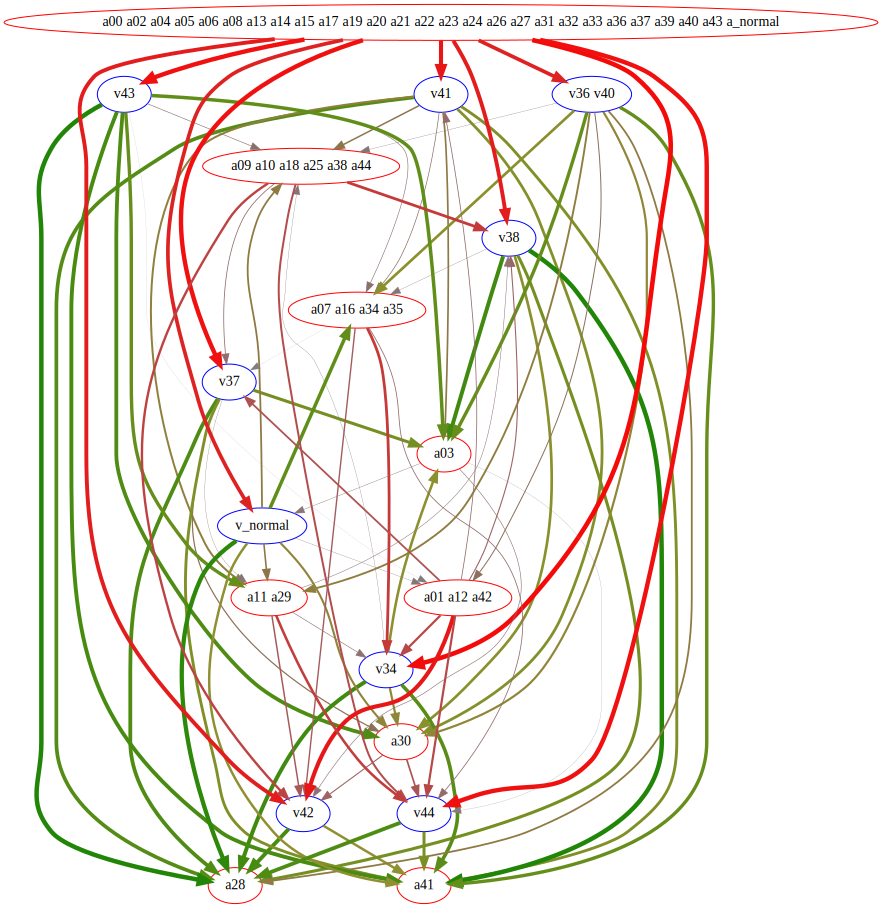

In [196]:
ps, G, edges_lst, edge_strength = plot_df_as_graph(df_clustered)
ps

In [162]:
def strength_for_cycle(cycle):
    strengths = []
#     cycle = cycle + [cycle[0]]
    for i in range(len(cycle) - 1):
        v1, v2 = cycle[i:i+2]
        e_idx = edges_lst.index([v1, v2])
        strength = edge_strength[e_idx]
        strengths.append(strength)
    return strengths

cycles = list(nx.simple_cycles(G))
cycles = [cycle + [cycle[0]] for cycle in cycles]
    
#Return a list of cycles described as a list o nodes
strengths = [strength_for_cycle(cycle) for cycle in cycles]
min_strength = [min(x) for x in strengths]

data = []
for idx in np.argsort(min_strength)[::-1]:
    data.append(dict(cycle=cycles[idx], edge_strength=strengths[idx], min_stength_percent=min_strength[idx] * 100))
pd.DataFrame(data)

,cycle,edge_strength,min_stength_percent
0,"[v_normal, a07 a16 a34 a35, v34, a03, v_normal]","[0.7, 0.56, 0.52, 0.08]",8.0
1,"[v38, a03, v_normal, a09 a10 a18 a25 a38 a44, ...","[0.8, 0.08, 0.36, 0.56]",8.0
2,"[v_normal, a11 a29, v34, a03, v_normal]","[0.32, 0.12, 0.52, 0.08]",8.0
3,"[v38, a03, v_normal, a11 a29, v38]","[0.8, 0.08, 0.32, 0.1]",8.0
4,"[v37, a03, v_normal, a09 a10 a18 a25 a38 a44, ...","[0.62, 0.08, 0.36, 0.16]",8.0
...,...,...,...
64,"[v37, a11 a29, v34, a03, v_normal, a07 a16 a34...","[0.06, 0.12, 0.52, 0.08, 0.7, 0.02]",2.0
65,"[v37, a11 a29, v38, a03, v_normal, a07 a16 a34...","[0.06, 0.1, 0.8, 0.08, 0.7, 0.02]",2.0
66,"[v37, a11 a29, v34, a03, v_normal, a01 a12 a42...","[0.06, 0.12, 0.52, 0.08, 0.06, 0.22, 0.06, 0.02]",2.0
67,"[v37, a03, v_normal, a01 a12 a42, v34, a09 a10...","[0.62, 0.08, 0.06, 0.44, 0.06, 0.56, 0.06, 0.02]",2.0


In [188]:
c_v, c_a

(['v_normal', 'v34', 'v_normal'], ['a07 a16 a34 a35', 'a03'])

In [189]:
df_cycle = df_clustered.copy()
c_a = [x for x in data[0]['cycle'] if x.startswith('a')]
c_v = [x for x in data[0]['cycle'][:-1] if x.startswith('v')]
# ps, G, edges_lst, edge_strength = plot_df_as_graph(df_clustered)


In [190]:
df_clustered

,v42,v41,v38,v37,v34,v36 v40,v43,v_normal,v44
a00 a02 a04 a05 a06 a08 a13 a14 a15 a17 a19 a20 a21 a22 a23 a24 a26 a27 a31 a32 a33 a36 a37 a39 a40 a43 a_normal,89.0,91.0,89.0,94.0,96.0,87.0,94.0,87.0,94.0
a09 a10 a18 a25 a38 a44,74.0,35.0,78.0,58.0,47.0,47.0,44.0,32.0,70.0
a07 a16 a34 a35,64.0,43.0,47.0,51.0,78.0,23.0,44.0,15.0,58.0
a28,11.0,13.0,19.0,12.0,10.0,32.0,5.0,7.0,12.0
a03,56.0,33.0,10.0,19.0,24.0,16.0,15.0,54.0,52.0
a01 a12 a42,91.0,58.0,61.0,68.0,72.0,40.0,49.0,47.0,72.0
a30,61.0,22.0,23.0,38.0,28.0,28.0,12.0,29.0,67.0
a41,25.0,21.0,5.0,21.0,14.0,16.0,11.0,25.0,20.0
a11 a29,65.0,30.0,55.0,47.0,56.0,31.0,16.0,34.0,76.0


In [191]:
df_cycle = df_cycle.loc[c_a, c_v]

In [192]:
df_cycle

,v_normal,v34
a07 a16 a34 a35,15.0,78.0
a03,54.0,24.0


In [193]:
df_cycle.loc['a03', 'v_normal']

54.0

Number of edges: 4 out of 4, sparsity 0.00%


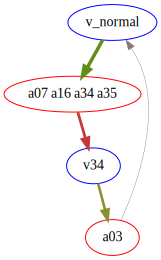

In [197]:
ps, G, edges_lst, edge_strength = plot_df_as_graph(df_cycle)
ps